# **Performing backpropagation of the neural network manually**

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
len(itos)

27

In [4]:
vocab_size = len(itos)
vocab_size

27

In [5]:
block_size = 3 # context length: how many characters do we take to predict the next one

def build_dataset(words):
  # build the dataset

  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '---->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

In [6]:
X, Y = build_dataset(words)

torch.Size([228146, 3]) torch.Size([228146])


In [7]:
import random

random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  max = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approx: {str(app):5s} | max: {max :.4f}')

In [9]:
n_emb = 10
n_hidden = 64

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g)

# Weights and bias
W1 = torch.randn((n_emb * block_size, n_hidden), generator=g) * (5/3) / (n_emb * block_size) ** 0.5
b1 = torch.randn(n_hidden, generator=g) * 0.1

W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1            # Non-zero
b2 = torch.randn(vocab_size, generator=g) * 0.1                        # Since (+)

bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.randn((1, n_hidden)) * 0.1

#batch_mean_running = torch.zeros((1, n_hidden))
#batch_std_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))

for params in parameters:
  params.requires_grad = True


4137


In [10]:
batch_size = 32
n = batch_size

ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
Xb, Yb = Xtr[ix], Ytr[ix]

In [11]:
# forward pass
emb = C[Xb]
embcat = emb.view(emb.shape[0], -1)

# linear layer 1
hprebn = embcat @ W1 + b1

# batch norm
bnmeani = 1 / n * hprebn.sum(0, keepdim = True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff ** 2

bnvar = 1 / (n -1) * (bndiff2).sum(0,keepdim = True)
bnvar_inv = (bnvar + 1e-5) ** -0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias

# non-linearity
h = torch.tanh(hpreact)

# linear layer 2
logits = h @ W2 + b2

# cross entropy loss
logit_maxes = logits.max(dim = 1, keepdim = True).values
norm_logits = logits - logit_maxes
counts = norm_logits.exp()
counts_sum = counts.sum(dim = 1, keepdim = True)
counts_sum_inv = counts_sum ** -1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()
print(loss)

for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv,
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss


tensor(3.3371, grad_fn=<NegBackward0>)


tensor(3.3371, grad_fn=<NegBackward0>)

In [12]:
logprobs.shape

torch.Size([32, 27])

In [13]:
logprobs[range(n), Yb]

tensor([-4.0311, -2.9819, -3.6523, -3.1949, -4.0918, -3.4804, -3.1895, -3.9604,
        -3.1707, -4.3185, -3.0729, -1.6510, -2.8187, -2.8728, -3.0539, -3.2078,
        -3.9542, -2.9665, -3.5485, -3.3537, -2.8585, -2.9726, -4.3352, -3.9869,
        -3.4841, -2.9785, -2.9755, -3.9133, -2.7782, -3.4376, -3.2804, -3.2136],
       grad_fn=<IndexBackward0>)

**loss = -logprobs[range(n), Yb].mean()**

```
dloss / dlogprobs
=> d(-logprobs[range(n), Yb].mean()) / dlogprobs

In short,
loss = (a + b + .... + n) / N
dloss / da = 1/N
.
.
.
dloss / dN = 1/N


so, dloss / dlogprobs = -(1/n)
```

In [14]:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1. / n
cmp('logprobs', dlogprobs, logprobs)

logprobs        | exact: True  | approx: True  | max: 0.0000


**logprobs = probs.log()**

```
dlogprobs / dprobs
=> d(probs.log()) / dprobs
=> 1 / probs

dloss / dprobs
=> der loss / der logprobs * der logprobs / der probs
=> dlogprobs * der logprobs / der probs
=> dlogprobs * (1 / probs)
```

In [15]:
dprobs = torch.zeros_like(probs)
dprobs = dlogprobs * (1/probs)
cmp('probs', dprobs, probs)


probs           | exact: True  | approx: True  | max: 0.0000


**probs = counts * counts_sum_inv**

```
der probs / der counts_sum_inv
=> der (counts * counts_sum_inv) / der counts_sum_inv
=> counts

der loss / der counts_sum_inv
=> der loss / der logprobs * der logprobs / der probs * der probs / der counts_sum_inv
=> dprobs * (der probs / der counts_sum_inv)
=> dprobs * counts
```

```
a(3 * 3) * b(3 * 1)

(a11b1 a12b1 a13b1).sum()
(a21b2 a22b2 a23b2).sum()
(a31b3 a32b3 a33b3).sum()
```

In [16]:
(counts_sum_inv.shape,
 counts.shape)


(torch.Size([32, 1]), torch.Size([32, 27]))

In [17]:
dcounts_sum_inv = torch.zeros_like(counts_sum_inv)
dcounts_sum_inv = (dprobs * counts).sum(1, keepdim = True)    # since diff size, summing up
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)

counts_sum_inv  | exact: True  | approx: True  | max: 0.0000


**probs = counts * counts_sum_inv**

```
der probs / der counts
=> der(counts * counts_sum_inv) / der counts
=> counts_sum_inv

dloss / dcounts
=> der loss / der logprobs * der logprobs / der probs * der probs / der counts
=> dprobs * der probs / der counts
=> dprobs * counts_sum_inv
```

In [18]:
(probs.shape,
 counts_sum_inv.shape,
 counts.shape)

(torch.Size([32, 27]), torch.Size([32, 1]), torch.Size([32, 27]))

In [19]:
dcounts = torch.zeros_like(counts)
dcounts = dprobs * counts_sum_inv

# there is another branch for dcounts and some grad needs to be added

**counts_sum_inv = counts_sum ^ -1**

```
der counts_sum_inv / der counts_sum
=> der (counts_sum ^ -1) / der counts_sum
=> (-1) * counts_sum ^ (-1-1)
=> (-1) * counts_sum ^ (-2)
=> -1 * counts_sum ** -2

dloss / dcounts_sum
=> der loss / der logprobs * der logprobs / der probs * der probs / der counts_sum_inv * der counts_sum_inv / der counts_sum
=> dcounts_sum_inv * (der counts_sum_inv / der counts_sum)
=> dcounts_sum_inv * (-1 * counts_sum ** -2)
```

In [20]:
(counts_sum.shape,
 counts_sum_inv.shape)

(torch.Size([32, 1]), torch.Size([32, 1]))

In [21]:
dcounts_sum = torch.zeros_like(counts_sum)
dcounts_sum = dcounts_sum_inv * (-1 * counts_sum ** -2)
cmp('counts_sum', dcounts_sum, counts_sum)

counts_sum      | exact: True  | approx: True  | max: 0.0000


**counts_sum = counts.sum(dim = 1, keepdim = True)**

```
der counts_sum / der counts
=> 1(counts.shape)

dloss / dcounts
=> der loss / der logprobs * der logprobs / der probs * der probs / der counts_sum_inv * der counts_sum_inv / der counts_sum * der counts_sum / der counts
=> dcount_sum * der counts_sum / der counts
=> dcount_sum * 1(counts.shape)
```

```
[a+b+c
 d+e+f
 g+h+i]

[a b c
 d e f
 g h i]


[der a+b+c/der a  der a+b+c/der b  der a+b+c/der c
 der d+e+f/der d  der d+e+f/der e  der d+e+f/der f
 der g+h+i/der g  der g+h+i/der h  der g+h+i/der i]   
```


In [22]:
print(f'{counts.shape} = {counts_sum.shape}')

torch.Size([32, 27]) = torch.Size([32, 1])


In [23]:
dcounts += (dcounts_sum * torch.ones_like(counts))
cmp('counts', dcounts, counts)

counts          | exact: True  | approx: True  | max: 0.0000


**counts = norm_logits.exp()**

```
der counts / der norm_logits
=> der(norm_logits.exp()) / der norm_logits
=> norm_logits.exp()

dloss / dnorm_logits
=> der loss / der logprobs * der logprobs / der probs * der probs / der counts_sum_inv * der counts_sum_inv / der counts_sum * der counts_sum / der counts * der counts / der norm_logits
=> dcounts * der counts / der norm_logits
=> dcounts * norm_logits.exp()
```


In [24]:
(counts.shape,
 norm_logits.shape)

(torch.Size([32, 27]), torch.Size([32, 27]))

In [25]:
dnorm_logits = torch.zeros_like(norm_logits)
dnorm_logits = dcounts * norm_logits.exp()
cmp('norm_logits', dnorm_logits, norm_logits)

norm_logits     | exact: True  | approx: True  | max: 0.0000


**norm_logits = logits - logit_maxes**

```
der norm_logits / der logits
=> der(logits - logit_maxes) / der logits
=> 1.0

dloss / dlogits
=> der loss / der logprobs * der logprobs / der probs * der probs / der counts_sum_inv * der counts_sum_inv / der counts_sum * der counts_sum / der counts * der counts / der norm_logits * der norm_logits / der logits
=> dnorm_logits * der norm_logits / der logits
=> dnorm_logits * 1.0
```

```
der norm_logits / der logits_maxes
=> der(logits - logit_maxes) / der logits
=> - 1.0(shape of logit_maxes)

dloss / dlogits_maxes
=> der loss / der logprobs * der logprobs / der probs * der probs / der counts_sum_inv * der counts_sum_inv / der counts_sum * der counts_sum / der counts * der counts / der norm_logits * der norm_logits / der logits
=> dnorm_logits * der norm_logits / der logits_maxes
=> dnorm_logits * -1.0(shape of logit_maxes)
```

In [26]:
print(f'{logits.shape} => {norm_logits.shape} * ({logits.shape} - {logit_maxes.shape})')


torch.Size([32, 27]) => torch.Size([32, 27]) * (torch.Size([32, 27]) - torch.Size([32, 1]))


In [27]:
dlogits_maxes = torch.zeros_like(logit_maxes)
dlogits_maxes = (dnorm_logits * -1.0).sum(1, keepdim = True)
cmp('logits_maxes', dlogits_maxes, logit_maxes)

logits_maxes    | exact: True  | approx: True  | max: 0.0000


In [28]:
dlogits = torch.zeros_like(logits)
dlogits = dnorm_logits * torch.ones(32,27)

# there is another branch for logits

**logit_maxes = logits.max(dim = 1, keepdim = True).values**

```
der logits_maxes / der logits
=> 1.0(if it is max num else 0)
=> sum of the row will be 1 for each row


dloss / dlogits
=> der loss / der logprobs * der logprobs / der probs * der probs / der counts_sum_inv * der counts_sum_inv / der counts_sum * der counts_sum / der counts * der counts / der norm_logits * der norm_logits / der logits_maxes * der logits_maxes / der logits
=> dlogits_maxes * der logits_maxes / der logits
=> dlogits_maxes * 1.0(across each row)
```

In [29]:
(logit_maxes.shape,
 logits.shape)


(torch.Size([32, 1]), torch.Size([32, 27]))

In [30]:
dlogits += F.one_hot(torch.argmax(logits, dim = 1), num_classes = vocab_size) * dlogits_maxes
cmp('logits', dlogits, logits)

logits          | exact: True  | approx: True  | max: 0.0000


**logits = h @ W2 + b2**

```
der logits / der h
=> der(h @ W2 + b2)
=> W2

dloss / dh
=> der loss / der logprobs * der logprobs / der probs * der probs / der counts_sum_inv * der counts_sum_inv / der counts_sum * der counts_sum / der counts * der counts / der norm_logits * der norm_logits / der logits_maxes * der logits_maxes / der logits * der logits / der h
=> dlogits * der logits / der h
=> dlogits * W2
```

In [31]:
h.shape, W2.shape, dlogits.shape

(torch.Size([32, 64]), torch.Size([64, 27]), torch.Size([32, 27]))

In [32]:
dh = torch.ones_like(h)
dh = dlogits @ W2.T
cmp('h', dh, h)

h               | exact: True  | approx: True  | max: 0.0000


**logits = h @ W2 + b2**

```
der logits / der W2
=> der(h @ W2 + b2)
=> h

dloss / dW2
=> der loss / der logprobs * der logprobs / der probs * der probs / der counts_sum_inv * der counts_sum_inv / der counts_sum * der counts_sum / der counts * der counts / der norm_logits * der norm_logits / der logits_maxes * der logits_maxes / der logits * der logits / der W2
=> dlogits * der logits / der W2
=> dlogits * h
```

In [33]:
dW2 = torch.ones_like(W2)
dW2 = h.T @ dlogits
cmp('W2', dW2, W2)

W2              | exact: True  | approx: True  | max: 0.0000


**logits = h @ W2 + b2**

```
der logits / der b2
=> der(h @ W2 + b2)
=> 1

dloss / db2
=> der loss / der logprobs * der logprobs / der probs * der probs / der counts_sum_inv * der counts_sum_inv / der counts_sum * der counts_sum / der counts * der counts / der norm_logits * der norm_logits / der logits_maxes * der logits_maxes / der logits * der logits / der b2
=> dlogits * der logits / der b2
=> dlogits * 1.0
```

In [34]:
b2.shape, logits.shape

(torch.Size([27]), torch.Size([32, 27]))

In [35]:
db2 = torch.ones_like(b2)
db2 = (dlogits * 1.0).sum(0, keepdim = True)
cmp('b2', db2, b2)

b2              | exact: True  | approx: True  | max: 0.0000


**h = torch.tanh(hpreact)**

```
der h * der hpreact
=> der(tanh(hpreact)) / der h
=> 1 - tan**2(hpreact)
=> 1 - h**2

dloss / hpreact2
=> der loss / der logprobs * der logprobs / der probs * der probs / der counts_sum_inv * der counts_sum_inv / der counts_sum * der counts_sum / der counts * der counts / der norm_logits * der norm_logits / der logits_maxes * der logits_maxes / der logits * der logits / der h * der h / hpreact
=> dh * der h / der hpreact
=> dh * (1 - (h**2))
```

In [36]:
h.shape, hpreact.shape

(torch.Size([32, 64]), torch.Size([32, 64]))

In [37]:
dhpreact = torch.ones_like(hpreact)
dhpreact = (1 - h**2) * dh
cmp('hpreact', dhpreact, hpreact)

hpreact         | exact: False | approx: True  | max: 0.0000


**hpreact = bngain * bnraw + bnbias**

```
der hpreact / der bngain
=> der (bngain * bnraw + bnbias) / der bngain
=> bnraw

dloss / hpreact2
=> der loss / der logprobs * der logprobs / der probs * der probs / der counts_sum_inv * der counts_sum_inv / der counts_sum * der counts_sum / der counts * der counts / der norm_logits * der norm_logits / der logits_maxes * der logits_maxes / der logits * der logits / der h * der h / der hpreact * der hpreact / der bngain
=> dhpreact * der hpreact / der bngain
=> dhpreact * bnraw
```

In [38]:
hpreact.shape, bnraw.shape, bngain.shape, bnbias.shape

(torch.Size([32, 64]),
 torch.Size([32, 64]),
 torch.Size([1, 64]),
 torch.Size([1, 64]))

In [39]:
dbngain = torch.ones_like(bngain)
dbngain = (dhpreact * bnraw).sum(0, keepdim = True)
cmp('bngain', dbngain, bngain)

bngain          | exact: False | approx: True  | max: 0.0000


**hpreact = bngain * bnraw + bnbias**

```
der hpreact / der bnraw
=> der (bngain * bnraw + bnbias) / der bnraw
=> bngain

dloss / hpreact2
=> der loss / der logprobs * der logprobs / der probs * der probs / der counts_sum_inv * der counts_sum_inv / der counts_sum * der counts_sum / der counts * der counts / der norm_logits * der norm_logits / der logits_maxes * der logits_maxes / der logits * der logits / der h * der h / der hpreact * der hpreact / der bnraw
=> dhpreact * der hpreact / der bnraw
=> dhpreact * bngain
```

In [40]:
dbnraw = torch.ones_like(bnraw)
dbnraw = (dhpreact * bngain)
cmp('bnraw', dbnraw, bnraw)

bnraw           | exact: False | approx: True  | max: 0.0000


**hpreact = bngain * bnraw + bnbias**

```
der hpreact / der bnbias
=> der (bngain * bnraw + bnbias) / der bnbias
=> 1.0

dloss / hpreact2
=> der loss / der logprobs * der logprobs / der probs * der probs / der counts_sum_inv * der counts_sum_inv / der counts_sum * der counts_sum / der counts * der counts / der norm_logits * der norm_logits / der logits_maxes * der logits_maxes / der logits * der logits / der h * der h / der hpreact * der hpreact / der bnbias
=> dhpreact * der hpreact / der bnbias
=> dhpreact * 1.0
```

In [41]:
dbnbias = torch.ones_like(bnraw)
dbnbias = (dhpreact * 1.0).sum(0, keepdim = True)
cmp('bnbias', dbnbias, bnbias)

bnbias          | exact: False | approx: True  | max: 0.0000


**bnraw = bndiff * bnvar_inv**

```
der bnraw / der bndiff
=> der (bndiff * bnvar_inv) / der bndiff
=> bnvar_inv

dloss / bnvar_inv
=> der loss / der logprobs * der logprobs / der probs * der probs / der counts_sum_inv * der counts_sum_inv / der counts_sum * der counts_sum / der counts * der counts / der norm_logits * der norm_logits / der logits_maxes * der logits_maxes / der logits * der logits / der h * der h / der hpreact * der hpreact / der bnraw * der bnraw / der bndiff
=> dbnraw * der bnraw / der bndiff
=> dbnraw * bnvar_inv
```

```
der bnraw / der bnvar_inv
=> der (bndiff * bnvar_inv) / der bnvar_inv
=> bndiff

dloss / bnvar_inv
=> der loss / der logprobs * der logprobs / der probs * der probs / der counts_sum_inv * der counts_sum_inv / der counts_sum * der counts_sum / der counts * der counts / der norm_logits * der norm_logits / der logits_maxes * der logits_maxes / der logits * der logits / der h * der h / der hpreact * der hpreact / der bnraw * der bnraw / der bnvar_inv
=> dbnraw * der bnraw / der bnvar_inv
=> dbnraw * bndiff
```

In [42]:
bndiff.shape, bnvar_inv.shape, dbnraw.shape

(torch.Size([32, 64]), torch.Size([1, 64]), torch.Size([32, 64]))

In [43]:
dbnvar_inv = torch.ones_like(bnvar_inv)
dbnvar_inv = (dbnraw * bndiff).sum(0, keepdim = True)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)

bnvar_inv       | exact: False | approx: True  | max: 0.0000


In [44]:
dbndiff = torch.ones_like(bndiff)
dbndiff = dbnraw * bnvar_inv

# there is another branch for dbndiff

**bnvar_inv = (bnvar + 1e-5) ^ -0.5**

```
der bnvar_inv / der bnvar
=> der((bnvar + 1e-5) ^ -0.5) / der bnvar
=> -0.5 * (bnvar + 1e-5) ** -1.5 * 1
=> -0.5 * (bnvar + 1e-5) ** -1.5

dloss / bnvar_inv
=> der loss / der logprobs * der logprobs / der probs * der probs / der counts_sum_inv * der counts_sum_inv / der counts_sum * der counts_sum / der counts * der counts / der norm_logits * der norm_logits / der logits_maxes * der logits_maxes / der logits * der logits / der h * der h / der hpreact * der hpreact / der bnraw * der bnraw / der bnvar_inv * der bnvar_inv / der bnvar
=> dbnvar_inv * der bnvar_inv / der bnvar
=> dbnvar_inv * -0.5 * ((bnvar + 1e-5) ** -1.5)
```

In [45]:
bnvar_inv.shape, bnvar.shape

(torch.Size([1, 64]), torch.Size([1, 64]))

In [46]:
dbnvar = torch.ones_like(bnvar)
dbnvar = dbnvar_inv * -0.5 * ((bnvar + 1e-5) ** -1.5)
cmp('bnvar', dbnvar, bnvar)

bnvar           | exact: False | approx: True  | max: 0.0000


**bnvar = 1 / (n -1) * (bndiff2).sum(0,keepdim = True)**

```
der bnvar / der bndiff2
=> der (1 / (n -1) * (bndiff2).sum()) / der bndiff
=> (1 / (n-1) )

dloss / bndiff2
=> der loss / der logprobs * der logprobs / der probs * der probs / der counts_sum_inv * der counts_sum_inv / der counts_sum * der counts_sum / der counts * der counts / der norm_logits * der norm_logits / der logits_maxes * der logits_maxes / der logits * der logits / der h * der h / der hpreact * der hpreact / der bnraw * der bnraw / der bnvar_inv * der bnvar_inv / der bnvar * der bnvar / der bndiff2
=> dbnvar * der bnvar / der bndiff2
=> dbnvar * (1 / (n - 1 ) )
```

In [47]:
bnvar.shape, bndiff2.shape

(torch.Size([1, 64]), torch.Size([32, 64]))

In [48]:
dbndiff2 = torch.ones_like(bndiff2)
dbndiff2 = dbnvar * (1 / (n - 1) * dbndiff2)
cmp('bndiff2', dbndiff2, bndiff2)

bndiff2         | exact: False | approx: True  | max: 0.0000


**bndiff2 = bndiff ^ 2**

```
der bndiff2 / der bndiff
=> der (bndiff ** 2) / der bndiff
=> 2 * (bndiff)

dloss / bndiff
=> der loss / der logprobs * der logprobs / der probs * der probs / der counts_sum_inv * der counts_sum_inv / der counts_sum * der counts_sum / der counts * der counts / der norm_logits * der norm_logits / der logits_maxes * der logits_maxes / der logits * der logits / der h * der h / der hpreact * der hpreact / der bnraw * der bnraw / der bnvar_inv * der bnvar_inv / der bnvar * der bnvar / der bndiff2 * der bndiff2 / bndiff
=> dbndiff2 * der bndiff2 / der bndiff
=> dbndiff2 * 2 * bndiff
```

In [49]:
dbndiff2.shape, dbndiff.shape

(torch.Size([32, 64]), torch.Size([32, 64]))

In [50]:
dbndiff += (2 * bndiff) * dbndiff2
cmp('bndiff', dbndiff, bndiff)

bndiff          | exact: False | approx: True  | max: 0.0000


**bndiff = hprebn - bnmeani**

```
der bndiff / der hprebn
=> der (hprebn - bnmeani) / der hprebn
=> 1.0

dloss / hprebn
=> der loss / der logprobs * der logprobs / der probs * der probs / der counts_sum_inv * der counts_sum_inv / der counts_sum * der counts_sum / der counts * der counts / der norm_logits * der norm_logits / der logits_maxes * der logits_maxes / der logits * der logits / der h * der h / der hpreact * der hpreact / der bnraw * der bnraw / der bnvar_inv * der bnvar_inv / der bnvar * der bnvar / der bndiff2 * der bndiff2 / der bndiff * der bndiff / der hprebn
=> dbndiff * der bndiff / der hprebn
=> dbndiff * 1.0
```

```
der bndiff / der bnmeani
=> der (hprebn - bnmeani) / der bnmeani
=> -1 (sum along 0th dim)

dloss / bnmeani
=> der loss / der logprobs * der logprobs / der probs * der probs / der counts_sum_inv * der counts_sum_inv / der counts_sum * der counts_sum / der counts * der counts / der norm_logits * der norm_logits / der logits_maxes * der logits_maxes / der logits * der logits / der h * der h / der hpreact * der hpreact / der bnraw * der bnraw / der bnvar_inv * der bnvar_inv / der bnvar * der bnvar / der bndiff2 * der bndiff2 / der bndiff * der bndiff / der hprebn
=> dbndiff * der bndiff / der hprebn
=> dbndiff * -1 (sum along 0th dim)
```

In [51]:
hprebn.shape, bnmeani.shape

(torch.Size([32, 64]), torch.Size([1, 64]))

In [52]:
dbnmeani = torch.ones_like(bnmeani)
dbnmeani = (dbndiff * -1).sum(0, keepdim = True)
cmp('bnmeani', dbnmeani, bnmeani)

bnmeani         | exact: False | approx: True  | max: 0.0000


In [53]:
dhprebn = torch.ones_like(hprebn)
dhprebn = dbndiff * 1.0

# there is another branch of hprebn

**bnmeani = 1 / n * hprebn.sum(0, keepdim = True)**

```
der bnmeani / der hprebn
=> der (1 / n * hprebn.sum()) / der hprebn
=> 1 / n

dloss / hprebn
=> der loss / der logprobs * der logprobs / der probs * der probs / der counts_sum_inv * der counts_sum_inv / der counts_sum * der counts_sum / der counts * der counts / der norm_logits * der norm_logits / der logits_maxes * der logits_maxes / der logits * der logits / der h * der h / der hpreact * der hpreact / der bnraw * der bnraw / der bnvar_inv * der bnvar_inv / der bnvar * der bnvar / der bndiff2 * der bndiff2 / der bndiff * der bndiff / der hprebn * der bndiff / der bnmeani * der bnmeani / der hprebn
=> dbnmeani * der bnmeani / der hprebn
=> dbnmeani * 1 / n
```

In [54]:
dhprebn += 1.0 /n * (torch.ones_like(hprebn) * dbnmeani)
cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: False | approx: True  | max: 0.0000


**hprebn = embcat @ W1 + b1**

```
der hprebn / der embcat
=> der (embcat @ W1 + b1) / der embcat
=> W1

dloss / embcat
=> der loss / der logprobs * der logprobs / der probs * der probs / der counts_sum_inv * der counts_sum_inv / der counts_sum * der counts_sum / der counts * der counts / der norm_logits * der norm_logits / der logits_maxes * der logits_maxes / der logits * der logits / der h * der h / der hpreact * der hpreact / der bnraw * der bnraw / der bnvar_inv * der bnvar_inv / der bnvar * der bnvar / der bndiff2 * der bndiff2 / der bndiff * der bndiff / der hprebn * der bndiff / der bnmeani * der meani / der hprebn * der hprebn / der embcat
=> dhprebn * der hprebn / der embcat
=> dhprebn * W1
```

```
der hprebn / der W1
=> der (embcat @ W1 + b1) / der W1
=> embcat

dloss / W1
=> der loss / der logprobs * der logprobs / der probs * der probs / der counts_sum_inv * der counts_sum_inv / der counts_sum * der counts_sum / der counts * der counts / der norm_logits * der norm_logits / der logits_maxes * der logits_maxes / der logits * der logits / der h * der h / der hpreact * der hpreact / der bnraw * der bnraw / der bnvar_inv * der bnvar_inv / der bnvar * der bnvar / der bndiff2 * der bndiff2 / der bndiff * der bndiff / der hprebn * der bndiff / der bnmeani * der meani / der hprebn * der hprebn / der W1
=> dhprebn * der hprebn / der W1
=> dhprebn * embcat
```

```
der hprebn / der b1
=> der (embcat @ W1 + b1) / der b1
=> 1.0

dloss / b1
=> der loss / der logprobs * der logprobs / der probs * der probs / der counts_sum_inv * der counts_sum_inv / der counts_sum * der counts_sum / der counts * der counts / der norm_logits * der norm_logits / der logits_maxes * der logits_maxes / der logits * der logits / der h * der h / der hpreact * der hpreact / der bnraw * der bnraw / der bnvar_inv * der bnvar_inv / der bnvar * der bnvar / der bndiff2 * der bndiff2 / der bndiff * der bndiff / der hprebn * der bndiff / der bnmeani * der meani / der hprebn * der hprebn / der b1
=> dhprebn * der hprebn / der b1
=> dhprebn * 1.0
```

In [55]:
print(f'{embcat.shape} => {dhprebn.shape} * {W1.shape}')


torch.Size([32, 30]) => torch.Size([32, 64]) * torch.Size([30, 64])


In [56]:
dembcat = torch.ones_like(embcat)
dembcat = dhprebn @ W1.T
cmp('embcat', dembcat, embcat)

embcat          | exact: False | approx: True  | max: 0.0000


In [57]:
print(f'{W1.shape} => {dhprebn.shape} * {embcat.shape}')

torch.Size([30, 64]) => torch.Size([32, 64]) * torch.Size([32, 30])


In [58]:
dW1 = torch.ones_like(W1)
dW1 = embcat.T @ dhprebn
cmp('W1', dW1, W1)

W1              | exact: False | approx: True  | max: 0.0000


In [59]:
dhprebn.shape, b1.shape

(torch.Size([32, 64]), torch.Size([64]))

In [60]:
db1 = torch.ones_like(b1)
db1 = (dhprebn * 1.0).sum(0, keepdim = True)
cmp('b1', db1, b1)

b1              | exact: False | approx: True  | max: 0.0000


**embcat = emb.view(emb.shape[0], -1)**

```
der embcat / der emb
=> der (emb.view(emb.shape[0], -1)) / der emb
=> 1.0

dloss / emb
=> der loss / der logprobs * der logprobs / der probs * der probs / der counts_sum_inv * der counts_sum_inv / der counts_sum * der counts_sum / der counts * der counts / der norm_logits * der norm_logits / der logits_maxes * der logits_maxes / der logits * der logits / der h * der h / der hpreact * der hpreact / der bnraw * der bnraw / der bnvar_inv * der bnvar_inv / der bnvar * der bnvar / der bndiff2 * der bndiff2 / der bndiff * der bndiff / der hprebn * der bndiff / der bnmeani * der meani / der hprebn * der hprebn / der embcat * der embcat / der emb
=> dembcat * der embcat / der emb
=> dembcat * 1.0(with change in shape)
```

In [61]:
embcat.shape, emb.shape

(torch.Size([32, 30]), torch.Size([32, 3, 10]))

In [62]:
demb = torch.ones_like(emb)
demb = (dembcat * 1.0).view(emb.shape)
cmp('emb', demb, emb)

emb             | exact: False | approx: True  | max: 0.0000


**emb = C[Xb]**

```
der emb / der C
=> der (C[Xb]) / der C
=> 1

dloss / C
=> der loss / der logprobs * der logprobs / der probs * der probs / der counts_sum_inv * der counts_sum_inv / der counts_sum * der counts_sum / der counts * der counts / der norm_logits * der norm_logits / der logits_maxes * der logits_maxes / der logits * der logits / der h * der h / der hpreact * der hpreact / der bnraw * der bnraw / der bnvar_inv * der bnvar_inv / der bnvar * der bnvar / der bndiff2 * der bndiff2 / der bndiff * der bndiff / der hprebn * der bndiff / der bnmeani * der meani / der hprebn * der hprebn / der embcat * der embcat / der emb * der emb / der C
=> demb * der emb / der C
=> demb * 1
```

In [63]:
emb.shape, C.shape, Xb.shape

(torch.Size([32, 3, 10]), torch.Size([27, 10]), torch.Size([32, 3]))

In [64]:
dC = torch.zeros_like(C)
for i in range(Xb.shape[0]):
  for j in range(Xb.shape[1]):
    dC[Xb[i, j]] += (demb[i,j] * 1.0)
cmp('C', dC, C)

C               | exact: False | approx: True  | max: 0.0000


In [65]:
dC.shape, C.shape,


(torch.Size([27, 10]), torch.Size([27, 10]))

# **In Summary**

In [66]:
# forward pass
emb = C[Xb]
embcat = emb.view(emb.shape[0], -1)

# linear layer 1
hprebn = embcat @ W1 + b1

# batch norm
bnmeani = 1 / n * hprebn.sum(0, keepdim = True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff ** 2

bnvar = 1 / (n -1) * (bndiff2).sum(0,keepdim = True)
bnvar_inv = (bnvar + 1e-5) ** -0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias

# non-linearity
h = torch.tanh(hpreact)

# linear layer 2
logits = h @ W2 + b2

# cross entropy loss
logit_maxes = logits.max(1, keepdim = True).values
norm_logits = logits - logit_maxes
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim = True)
counts_sum_inv = counts_sum ** -1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()
print(loss)

for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv,
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss


tensor(3.3371, grad_fn=<NegBackward0>)


tensor(3.3371, grad_fn=<NegBackward0>)

In [67]:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1. / n

dprobs = torch.zeros_like(probs)
dprobs = dlogprobs * (1/probs)

dcounts_sum_inv = torch.zeros_like(counts_sum_inv)
dcounts_sum_inv = (dprobs * counts).sum(1, keepdim = True)    # since diff size, summing up

dcounts = torch.zeros_like(counts)
dcounts = dprobs * counts_sum_inv

dcounts_sum = torch.zeros_like(counts_sum)
dcounts_sum = dcounts_sum_inv * (-1 * counts_sum ** -2)

dcounts += (dcounts_sum * torch.ones_like(counts))

dnorm_logits = torch.zeros_like(norm_logits)
dnorm_logits = dcounts * norm_logits.exp()

dlogits_maxes = torch.zeros_like(logit_maxes)
dlogits_maxes = (dnorm_logits * -1.0).sum(1, keepdim = True)

dlogits = torch.zeros_like(logits)
dlogits = dnorm_logits * torch.ones(32,27)

dlogits += F.one_hot(torch.argmax(logits, dim = 1), num_classes = vocab_size) * dlogits_maxes

dh = torch.ones_like(h)
dh = dlogits @ W2.T

dW2 = torch.ones_like(W2)
dW2 = h.T @ dlogits

db2 = torch.ones_like(b2)
db2 = (dlogits * 1.0).sum(0, keepdim = True)

dhpreact = torch.ones_like(hpreact)
dhpreact = (1 - h**2) * dh

dbngain = torch.ones_like(bngain)
dbngain = (dhpreact * bnraw).sum(0, keepdim = True)

dbnraw = torch.ones_like(bnraw)
dbnraw = (dhpreact * bngain)

dbnbias = torch.ones_like(bnraw)
dbnbias = (dhpreact * 1.0).sum(0, keepdim = True)

dbnvar_inv = torch.ones_like(bnvar_inv)
dbnvar_inv = (dbnraw * bndiff).sum(0, keepdim = True)

dbndiff = torch.ones_like(bndiff)
dbndiff = dbnraw * bnvar_inv

dbnvar = torch.ones_like(bnvar)
dbnvar = dbnvar_inv * -0.5 * ((bnvar + 1e-5) ** -1.5)

dbndiff2 = torch.ones_like(bndiff2)
dbndiff2 = dbnvar * (1 / (n - 1) * dbndiff2)

dbndiff += (2 * bndiff) * dbndiff2

dbnmeani = torch.ones_like(bnmeani)
dbnmeani = (dbndiff * -1).sum(0, keepdim = True)

dhprebn = torch.ones_like(hprebn)
dhprebn = dbndiff * 1.0

dhprebn += 1.0 /n * (torch.ones_like(hprebn) * dbnmeani)

dembcat = torch.ones_like(embcat)
dembcat = dhprebn @ W1.T

dW1 = torch.ones_like(W1)
dW1 = embcat.T @ dhprebn

db1 = torch.ones_like(b1)
db1 = (dhprebn * 1.0).sum(0, keepdim = True)

demb = torch.ones_like(emb)
demb = (dembcat * 1.0).view(emb.shape)

dC = torch.zeros_like(C)
for i in range(Xb.shape[0]):
  for j in range(Xb.shape[1]):
    dC[Xb[i, j]] += (demb[i,j] * 1.0)

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logits_maxes', dlogits_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnraw', dbnraw, bnraw)
cmp('bnbias', dbnbias, bnbias)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approx: True  | max: 0.0000
probs           | exact: True  | approx: True  | max: 0.0000
counts_sum_inv  | exact: True  | approx: True  | max: 0.0000
counts_sum      | exact: True  | approx: True  | max: 0.0000
counts          | exact: True  | approx: True  | max: 0.0000
norm_logits     | exact: True  | approx: True  | max: 0.0000
logits_maxes    | exact: True  | approx: True  | max: 0.0000
logits          | exact: True  | approx: True  | max: 0.0000
h               | exact: True  | approx: True  | max: 0.0000
W2              | exact: True  | approx: True  | max: 0.0000
b2              | exact: True  | approx: True  | max: 0.0000
hpreact         | exact: False | approx: True  | max: 0.0000
bngain          | exact: False | approx: True  | max: 0.0000
bnraw           | exact: False | approx: True  | max: 0.0000
bnbias          | exact: False | approx: True  | max: 0.0000
bnvar_inv       | exact: False | approx: True  | max: 0.0000
bnvar           | exact:

## **Back-prop for the cross-entropy**

```
logit_maxes = logits.max(1, keepdim = True).values
norm_logits = logits - logit_maxes
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim = True)
counts_sum_inv = counts_sum ** -1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()
```



In [68]:
dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp('logits', dlogits, logits)

logits          | exact: False | approx: True  | max: 0.0000


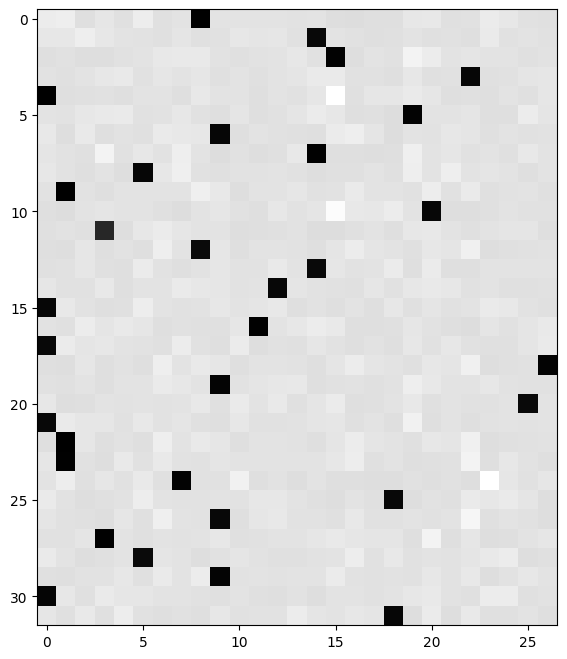

In [69]:
plt.figure(figsize = (8,8))
plt.imshow(dlogits.detach(), cmap = 'gray')

## **Back-prop for the batch-norm**

```
bnmeani = 1 / n * hprebn.sum(0, keepdim = True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff ** 2

bnvar = 1 / (n -1) * (bndiff2).sum(0,keepdim = True)
bnvar_inv = (bnvar + 1e-5) ** -0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
```

In [70]:
hpreact.shape, bnraw.shape

(torch.Size([32, 64]), torch.Size([32, 64]))

In [71]:
dhprebn = bngain * bnvar_inv / n * (n * dhpreact - dhpreact.sum(0) - n / (n-1) * bnraw * (dhpreact * bnraw).sum(0))
cmp('hpreact', dhpreact, hpreact)

hpreact         | exact: False | approx: True  | max: 0.0000


## **Back-prop final implementation**

In [72]:
# forward pass ---------------
emb = C[Xb]
embcat = emb.view(emb.shape[0], -1)

# linear layer 1
hprebn = embcat @ W1 + b1

# batch norm
bnmeani = 1 / n * hprebn.sum(0, keepdim = True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff ** 2

bnvar = 1 / (n -1) * (bndiff2).sum(0,keepdim = True)
bnvar_inv = (bnvar + 1e-5) ** -0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias

# non-linearity
h = torch.tanh(hpreact)

# linear layer 2
logits = h @ W2 + b2

# cross entropy loss
logit_maxes = logits.max(1, keepdim = True).values
norm_logits = logits - logit_maxes
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim = True)
counts_sum_inv = counts_sum ** -1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()
print(loss)

for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv,
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
# -------------------

tensor(3.3371, grad_fn=<NegBackward0>)


In [73]:
# backprop -----------
# output layer
dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n

# 2nd layer
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = (dlogits * 1.0).sum(0)

# tanh
dhpreact = (1 - h**2) * dh

# back-norm
dbnbias = (dhpreact * 1.0).sum(0, keepdim = True)
dbngain = (dhpreact * bnraw).sum(0, keepdim = True)
dhprebn = bngain * bnvar_inv / n * (n * dhpreact - dhpreact.sum(0) - n / (n-1) * bnraw * (dhpreact * bnraw).sum(0))

# firstlayer
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = (dhprebn * 1.0).sum(0)

# embedding
demb = (dembcat * 1.0).view(emb.shape)
dC = torch.zeros_like(C)
for i in range(Xb.shape[0]):
  for j in range(Xb.shape[1]):
    dC[Xb[i, j]] += (demb[i,j] * 1.0)

grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
# -------------------

In [75]:
# upgrade -----------
lr = 0.1
for p, grad in zip(parameters, grads):
  p.data += -lr * grad
# -------------------

## **Entire linear model witb manual back-propagation**

In [79]:
n_emb = 10
n_hidden = 64

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g)

# Weights and bias
W1 = torch.randn((n_emb * block_size, n_hidden), generator=g) * (5/3) / (n_emb * block_size) ** 0.5
b1 = torch.randn(n_hidden, generator=g) * 0.1

W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1            # Non-zero
b2 = torch.randn(vocab_size, generator=g) * 0.1                        # Since (+)

bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.randn((1, n_hidden)) * 0.1

#batch_mean_running = torch.zeros((1, n_hidden))
#batch_std_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))

for params in parameters:
  params.requires_grad = True


4137


In [80]:
lr = 0.12
epochs = 70000
batch_size = 32
n = batch_size
losses = []

with torch.no_grad():
  for epoch in range(epochs + 1):
    ix = torch.randint(0, X.shape[0], (batch_size,))
    Xb, Yb = X[ix], Y[ix]

    # forward pass ---------------
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)

    # linear layer 1
    hprebn = embcat @ W1 + b1

    # batch norm
    bnmean = hprebn.mean(0, keepdim = True)
    bnvar = hprebn.var(0,keepdim = True, unbiased = True)
    bnvar_inv = (bnvar + 1e-5) ** -0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias

    # non-linearity
    h = torch.tanh(hpreact)

    # linear layer 2
    logits = h @ W2 + b2

    # cross entropy loss
    loss = F.cross_entropy(logits, Yb)
    losses.append(loss.item())
    if epoch % 10000 == 0:
      print(f'{epoch} / {epochs} : loss => {loss.item() : .4f} {"# " * (epoch//10000)}')

    for p in parameters:
      p.grad = None

    # -------------------

    # backprop -----------
    # output layer
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n

    # 2nd layer
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = (dlogits * 1.0).sum(0)

    # tanh
    dhpreact = (1 - h**2) * dh

    # back-norm
    dbngain = (dhpreact * bnraw).sum(0, keepdim = True)
    dbnbias = (dhpreact * 1.0).sum(0, keepdim = True)
    dhprebn = bngain * bnvar_inv / n * (n * dhpreact - dhpreact.sum(0) - n / (n-1) * bnraw * (dhpreact * bnraw).sum(0))

    # firstlayer
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = (dhprebn * 1.0).sum(0)

    # embedding
    demb = (dembcat * 1.0).view(emb.shape)
    dC = torch.zeros_like(C)
    for i in range(Xb.shape[0]):
      for j in range(Xb.shape[1]):
        dC[Xb[i, j]] += (demb[i,j] * 1.0)

    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -------------------

    # upgrade -----------
    lr = 0.1 if epoch < 50000 else 0.01
    for p, grad in zip(parameters, grads):
      p.data += -lr * grad
    # -------------------



0 / 70000 : loss =>  3.5286 
10000 / 70000 : loss =>  2.4218 # 
20000 / 70000 : loss =>  2.2394 # # 
30000 / 70000 : loss =>  1.9767 # # # 
40000 / 70000 : loss =>  2.3623 # # # # 
50000 / 70000 : loss =>  2.2283 # # # # # 
60000 / 70000 : loss =>  2.1087 # # # # # # 
70000 / 70000 : loss =>  1.9477 # # # # # # # 


In [81]:
# for evalution of the model
# for p,g in zip(parameters, grads):
#   cmp(str(tuple(p.shape)), g, p)

In [80]:
with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [85]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(x, y):
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(f'loss : {loss.item() : .4f}')

split_loss(X, Y)


loss :  2.1817


In [86]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # ------------
      # forward pass:
      # Embedding
      emb = C[torch.tensor([context])] # (1,block_size,d)
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # ------------
      # Sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

mria.
gmyanniee.
medhayla.
rethruthadrie.
caderedieliah.
miloen.
edellean.
aarielleiorone.
cayshubergihiriel.
kindretlyn.
joberlyn.
brey.
dariyah.
fael.
yuma.
myston.
azhil.
salynn.
ustullel.
juren.
